## Imports

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import torch
from torchinfo import summary
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from TumorDetection.data.loader import DataPathLoader
from TumorDetection.data.dataset import TorchDataset, Dataset
from TumorDetection.utils.dict_classes import DataPathDir, Device, ReportingPathDir, Verbosity
from TumorDetection.models.efsnet import EFSNet
from TumorDetection.models.utils.lightning_model import LightningModel
from TumorDetection.models.utils.trainer import Trainer
from TumorDetection.models.utils.load import load_model
from TumorDetection.utils.viewer import Viewer

## Configuration Params

In [2]:
MODEL_NAME = 'EFSNet_clf_seg'
DESCRIPTION = 'EFSNet with classification and binary segmentation.'
CLASS_WEIGHTS = [1., 3., 3.]
POS_WEIGHT = 5
FROM_CHECKPOINT = False
VALIDATE = True
TEST = True
BATCH_SIZE = 32
VERBOSE = Verbosity.get('verbose')
DEVICE = Device.get('device')

## Path Finder

If not using DataPathLoader (*for BUSI Dataset*) consider passing paths as tuple of:  
- Image path
- List images masks paths associated
- List of associated label mask.

In [3]:
dp = DataPathLoader(DataPathDir.get('dir_path'))
paths = dp()

## Train Test Datasets

In [4]:
tr_paths, val_paths = train_test_split(paths, test_size=100, random_state=0, shuffle=True)
tr_td = TorchDataset(tr_paths,
                     crop_prob=None, rotation_degrees=None, 
                     range_brightness=None, range_contrast=None,range_saturation=None,
                     horizontal_flip_prob=None, vertical_flip_prob=None)
val_td = TorchDataset(val_paths,
                      crop_prob=None, rotation_degrees=None, 
                     range_brightness=None, range_contrast=None,range_saturation=None,
                     horizontal_flip_prob=None, vertical_flip_prob=None)

train_data = DataLoader(tr_td,
                        batch_size=BATCH_SIZE,
                        drop_last=True,
                        shuffle=False)

val_data = DataLoader(val_td,
                      batch_size=BATCH_SIZE,
                      drop_last=True,
                      shuffle=False)

## Model definition.

In [5]:
lightningmodel = LightningModel(model=EFSNet(device=DEVICE,
                                            verbose=VERBOSE),
                                model_name=MODEL_NAME,
                                description=DESCRIPTION,
                                class_weights=CLASS_WEIGHTS,
                                pos_weight=POS_WEIGHT,
                                device=DEVICE)
lightningmodel = load_model(directory=os.path.join(ReportingPathDir.get('dir_path'), 'ckpt'),
                            model_name=MODEL_NAME,
                            lightningmodel=lightningmodel)
print(summary(lightningmodel, lightningmodel.model.input_shape, 
              batch_dim=0,
              col_names=("input_size", "output_size", "num_params", "params_percent"),
              depth=3,
              row_settings=["var_names"],
        device=lightningmodel.device,))

Layer (type (var_name))                                           Input Shape               Output Shape              Param #                   Param %
LightningModel (LightningModel)                                   [1, 1, 256, 256]          [1, 1, 256, 256]          --                             --
├─EFSNet (model)                                                  [1, 1, 256, 256]          [1, 1, 256, 256]          --                             --
│    └─Encoder (encoder)                                          [1, 1, 256, 256]          [1, 64, 64, 64]           --                             --
│    │    └─InitialBlock (initial_block)                          [1, 1, 256, 256]          [1, 16, 128, 128]         166                         0.09%
│    │    └─DownsamplingBlock (downsampling_block1)               [1, 16, 128, 128]         [1, 64, 64, 64]           5,732                       3.04%
│    │    └─Sequential (factorized_blocks)                        [1, 64, 64, 64]       

## Prediction

### 1. Training first batch

In [6]:
batch = next(iter(train_data))
y_pred = lightningmodel.predict_step(batch, batch_idx=torch.tensor(0.))

In [7]:
seglab, seg, lab = y_pred

In [8]:
seglab.shape

torch.Size([32, 1, 256, 256])

In [9]:
seg.shape

torch.Size([32, 1, 256, 256])

In [10]:
lab.shape

torch.Size([32])

In [11]:
view = Viewer()

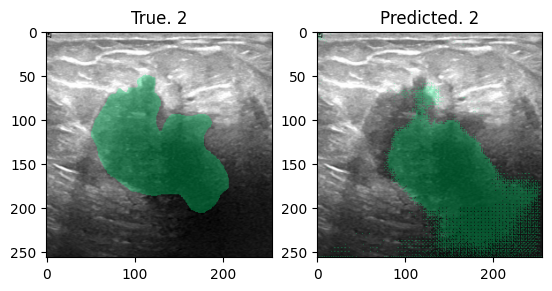

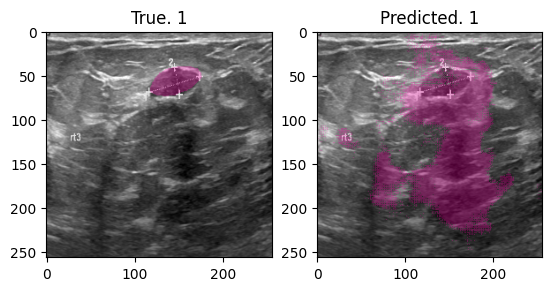

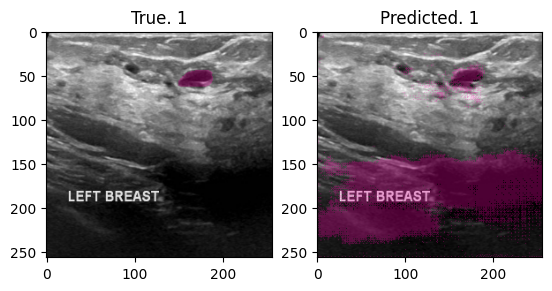

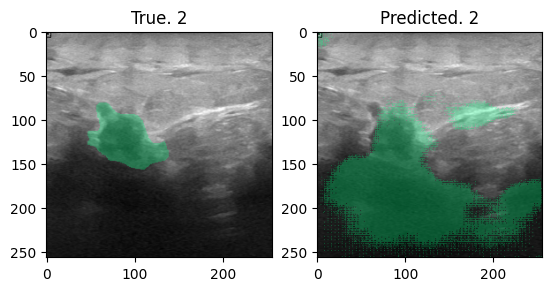

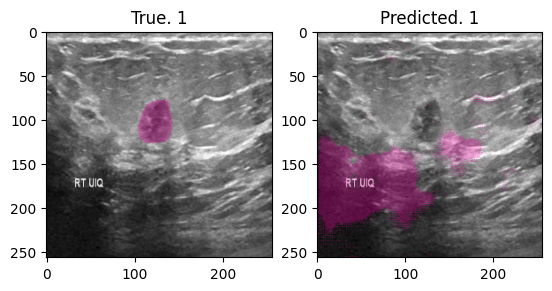

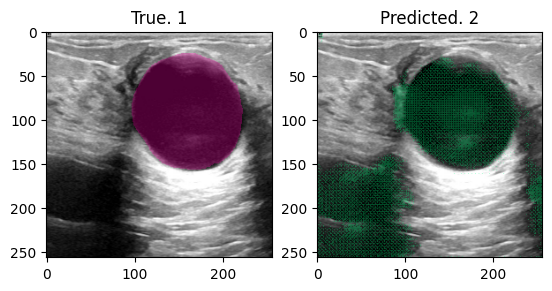

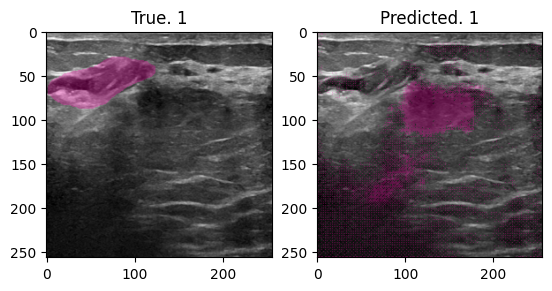

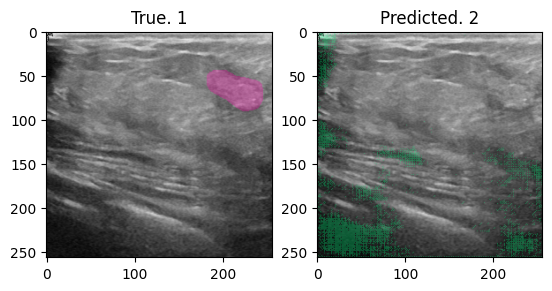

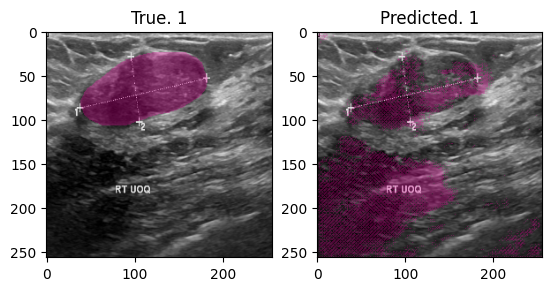

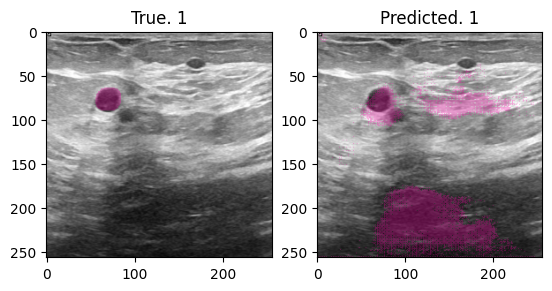

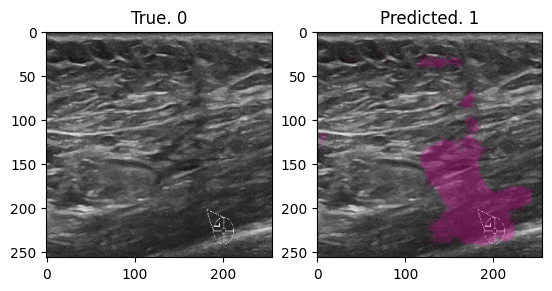

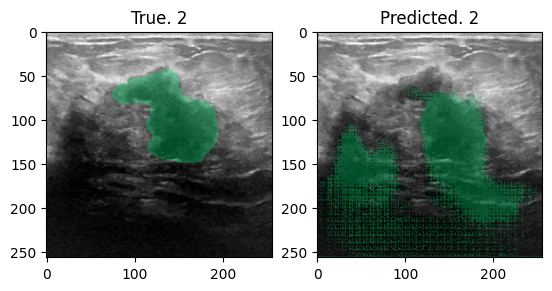

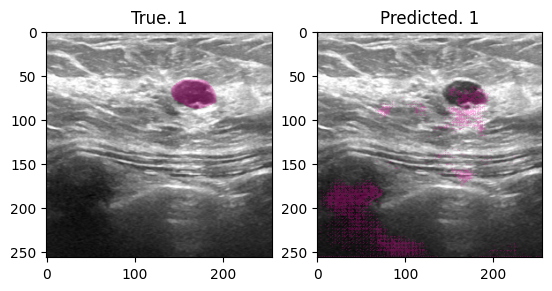

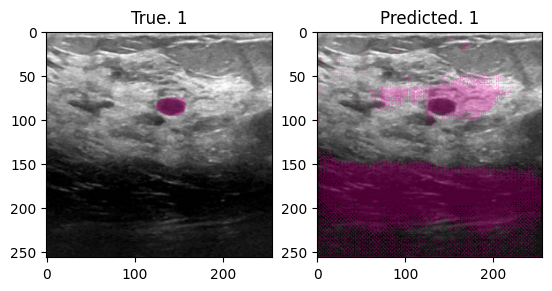

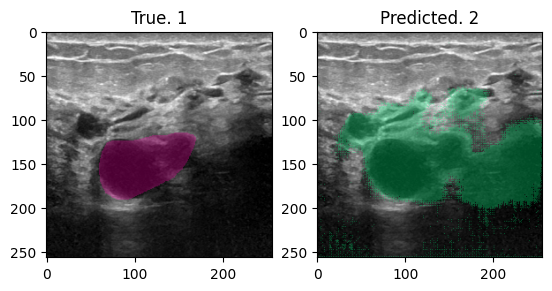

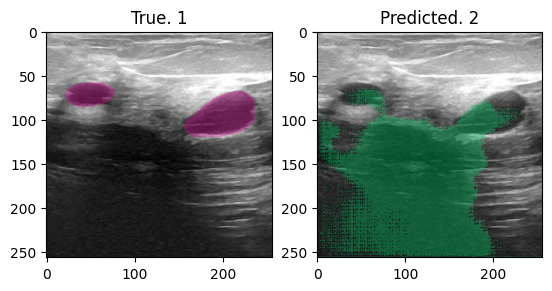

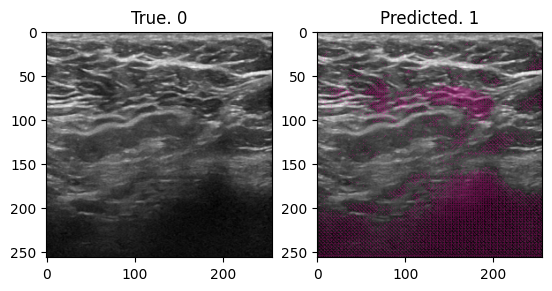

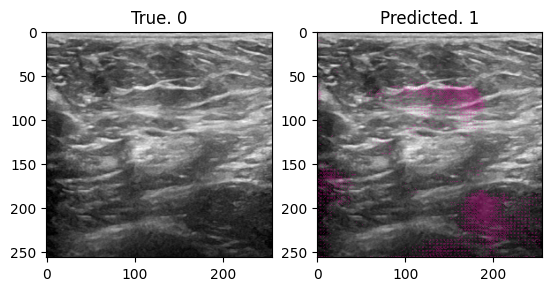

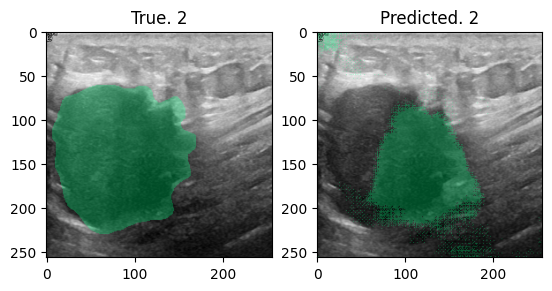

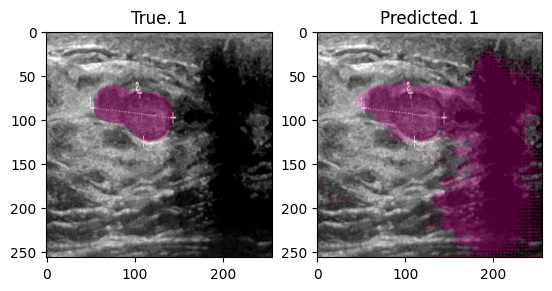

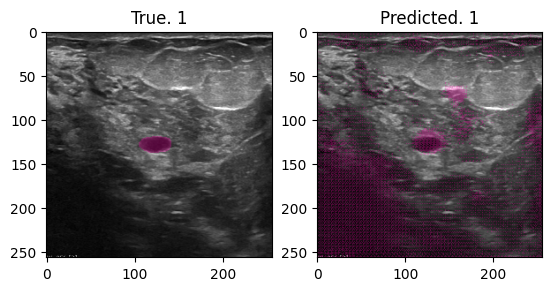

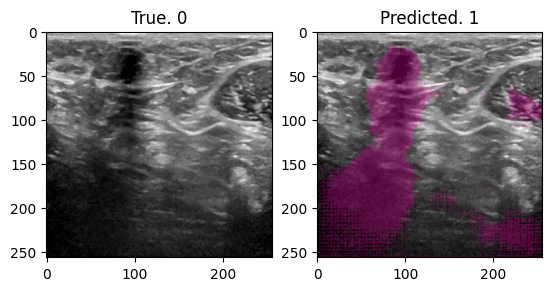

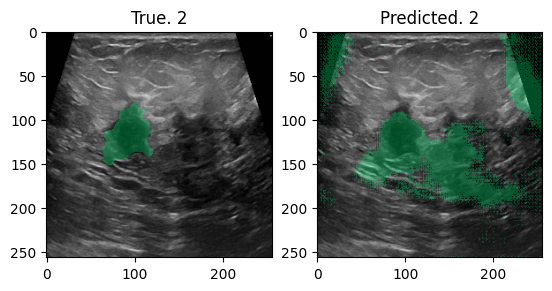

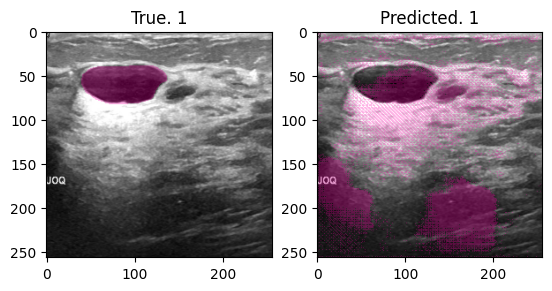

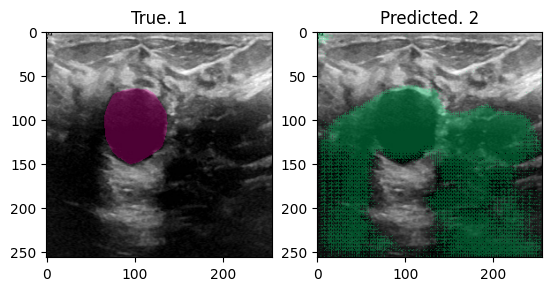

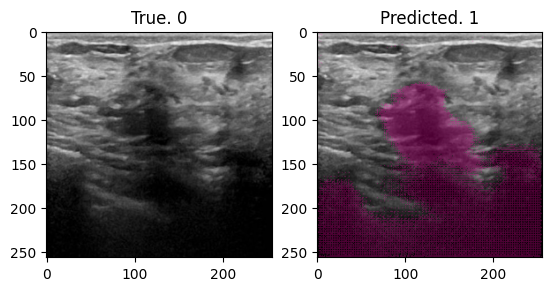

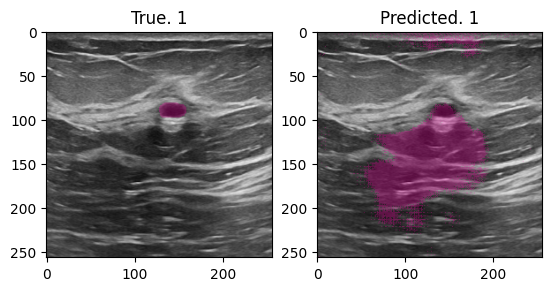

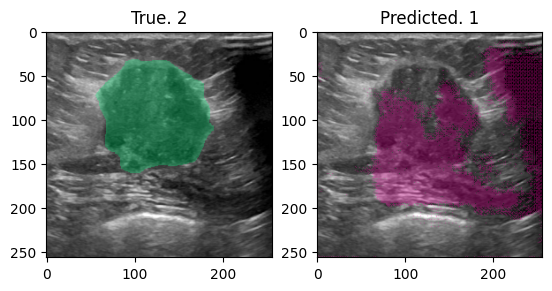

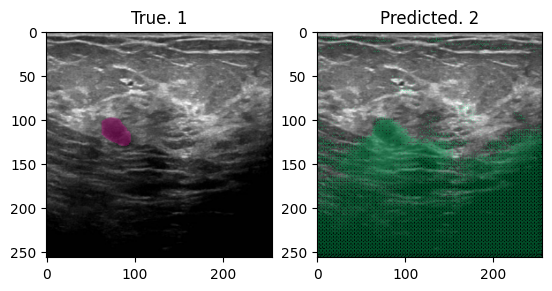

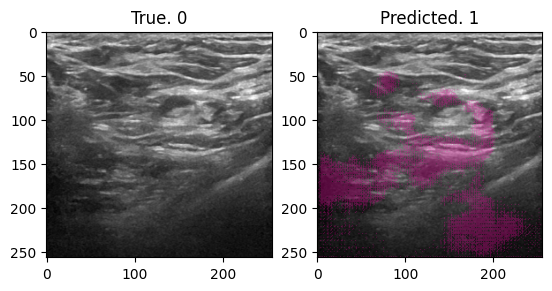

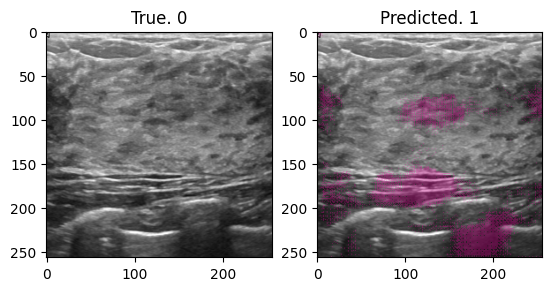

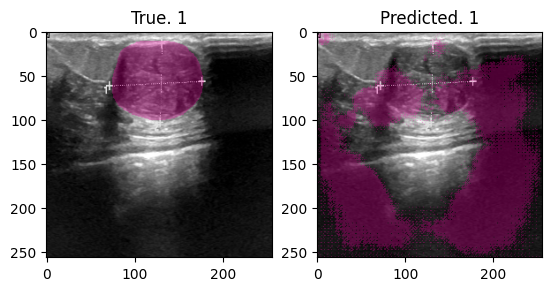

In [25]:
def torch2numpy_image(torchimage, scale=255.):
    torchimage = torchimage.permute(1, 2, 0).cpu().numpy()
    return (torchimage*scale).astype(np.uint8)
    
for image, mask, label, seg_mask, pred_label in zip(batch[0], batch[1], batch[2], seg, lab):
    img = torch2numpy_image(image)
    mask = torch2numpy_image(mask, scale = 255./label.item() if label.item() > 0 else 255.)
    pred_mask = torch2numpy_image(torch.gt(seg_mask, 0.5).to(torch.int32),
                                  scale = 255./pred_label.item() if pred_label.item() > 0 else 255.)
    true = view.get_masked_image(img, mask.squeeze())
    pred = view.get_masked_image(img, pred_mask.squeeze())
    a0 = plt.subplot(1, 2, 1)
    a0.imshow(true)    
    a0.set_title(f'True. {int(label.cpu().numpy())}')
    a1 = plt.subplot(1, 2, 2)
    a1.imshow(pred)    
    a1.set_title(f'Predicted. {int(pred_label.cpu().numpy())}')
    plt.show()